In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
plt.rcparams = {"fontsize": 16}

fig_params = {"dpi": 100, "figsize": (7, 7)}

In [27]:
def F(t, alpha = 0):
    result = 0
    for n in np.arange(1, K + 1):
        result += np.cos(k * d * n * (t - alpha))
    return result * 2 * ND + ND


def Fexp(t, alpha = 0):
    result = 0 + 0j
    for n in np.arange(0, K):
        result += np.exp(-1j * (k * d * (n - K) * (t - alpha))) + np.exp(1j * (k * d * (n - K) * (t - alpha))) 
    return result * ND + ND


def gauss_func(x, mean=0, var=1):
    return 1/(np.pi * 2 * np.sqrt(var)) * np.exp(-(x - mean)**2/(2 * var))


def signal_func(x, pos = [0.15, 0.45], var = 0.000001, magnitude = 600):
    pos = np.array(pos)
    var = np.array(var)
    signal = np.zeros_like(x)
    for idx, target in enumerate(pos):
        signal += gauss_func(x, target, var)
    return signal / np.max(signal) * magnitude


Idel = lambda t: signal_func(t, pos = targets, magnitude = magnitude)


def integrand(t, alpha):
    return np.real(Fexp(t - alpha)) * Idel(t)


def U00(a):
    return integrate.quad(integrand, -s1, s1, args = (a, ))[0]


vec_U00 = np.vectorize(U00)


def integrand_Cn(t, n = 1):
    return np.cos(k * d * n * t) * Idel(t)


def integral_of_func(func, lower = -1, upper = 1, N = 1000, **kwargs):
    h = (upper - lower) / N
    array_1d = np.arange(lower + h, upper + h, h)
    result = np.sum(func(array_1d, **kwargs) * h)
    return result 


int_func = np.vectorize(integral_of_func)


def CnU(x, Cn):
    result = 0
    for n, c in enumerate(Cn[1:]):
        result += c * np.exp(-1j * (k * d * (n + 1) * (x))) + c * np.exp(1j * (k * d * (n + 1) * (x)))
    return result + Cn[0] * np.exp(1j * (k * d * (0) * (x)))


def rel_squared_error(x, y):
    return np.sum((x - y) ** 2) / np.sum(x**2)


def rel_abs_error(x, y):
    return np.sum(np.abs(x - y)) / np.sum(np.abs(x))


def MAE(x, y):
    return np.sum(np.abs(x - y)) / x.shape[0]


def MSE(x, y):
    return np.sum(np.power(x - y, 2)) / x.shape[0]


def find_maxes(array, filter_maxes = False, filter_level = 1/np.sqrt(2)):
    maxes_pos = []
    maxes_values = []
    for idx, element in enumerate(array[1:-1]):
        if (np.real(element) > np.real(array[idx])) and (np.real(element) > np.real(array[idx + 2])):
            maxes_pos.append(idx + 1)
            maxes_values.append(element)
        
    maxes_pos = np.array(maxes_pos)
    maxes_values = np.array(maxes_values)
    
    if filter_maxes:
        indexes = np.where(maxes_values > np.max(maxes_values) * filter_level)[0]
        maxes_pos = maxes_pos[indexes]
        maxes_values = maxes_values[indexes]
        
    return (np.array(maxes_pos), np.array(maxes_values))

In [5]:
# Количество приемных устройств
K = 15

# Расстояние между приемниками
d = 0.7
d1 = 2 * np.pi * d


M = 2 * K

# k - волновое число
k = 2 * np.pi

# ND
ND = 100 / (2 * K + 1)
ND = 1

# Один радиан в градусах
rad_in_grad = 180 / np.pi 

# Отход от центра наблюдения целей
s = 1/ (0.82 * (M + 1) * d * 2)
s1 = 1.4 * s
dt = 0.1 * s
ds = 0.2 * s
ds1 = 0.01 * s1
sss = 0.01

# Сетки
dtn = np.arange(-s, s + dt, dt)
a = np.arange(-s1, s1 + ds1, ds1)
a1 = np.arange(0, 0.125 * k + ds, ds)

In [6]:
magnitude = 600
targets = [-0.02, 0.02]

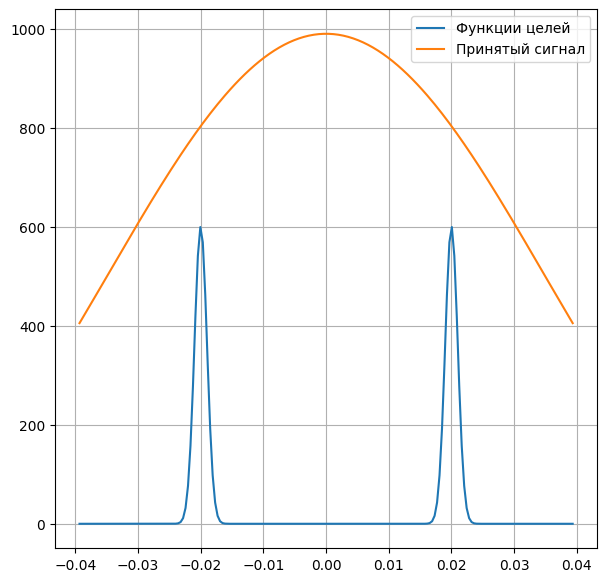

In [7]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.legend()
plt.grid()
plt.show()

In [8]:
NP = 200
NPa = np.arange(0, NP + 1)

In [9]:
Cn = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = NPa)

In [10]:
C = Cn[:K+1]
CR = Cn[K+1:]

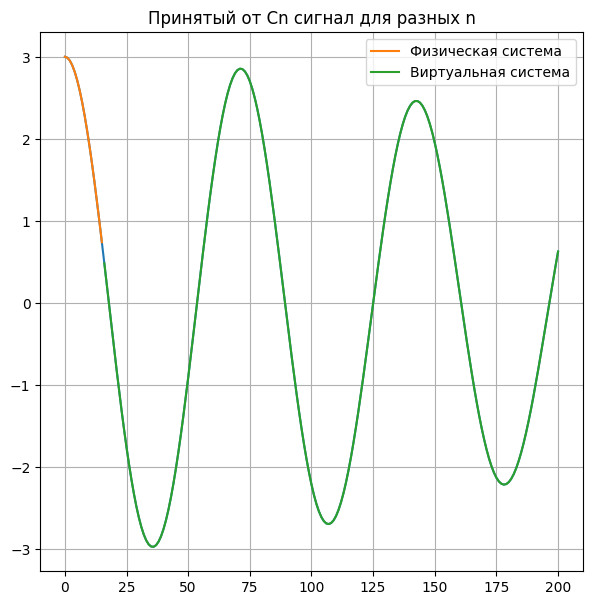

In [11]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.legend()
plt.grid()

## Модель затухающих колебаний

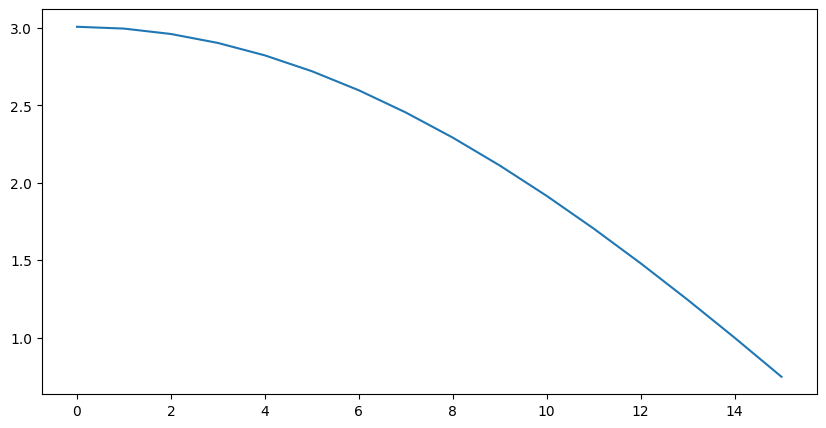

In [45]:
signal = lambda x, A, alpha, beta, epsilon: A * np.exp(alpha * x) * np.sin(beta * x + epsilon)
data = np.vstack([NPa[:K+1], C])

plt.figure(figsize = (10, 5))
plt.plot(data[0], data[1])
plt.show()

In [13]:
def grad_signal(x, data, A, alpha, beta, epsilon, clip = 255):
    grad = np.zeros(4)
    errors = signal(x, A, alpha, beta, epsilon) - data
    grad[0] = np.sum(errors * np.exp(alpha * x) * np.sin(beta * x + epsilon))
    grad[1] = np.sum(errors * A * x * np.exp(alpha * x) * np.sin(beta * x + epsilon))
    grad[2] = np.sum(errors * A * np.exp(alpha * x) * np.cos(beta * x + epsilon) * x)
    grad[3] = np.sum(errors * A * np.exp(alpha * x) * np.cos(beta * x + epsilon))
    return np.clip(grad / len(x), -clip, clip)

In [14]:
params_0 = np.array([data[1, 0], 0, 0 , 1.57])
params = np.zeros(4)
n_steps = 20000
speed = 0.001

num_of_data = data.shape[1]
batch_size = num_of_data // 1

for step in np.arange(n_steps):
    for start_index in range(0, num_of_data, batch_size):
        x_batch = data[0, start_index:start_index + batch_size]
        y_batch = data[1, start_index:start_index + batch_size]
        params = params_0 - speed * grad_signal(x_batch, y_batch, 
                                                params_0[0],
                                                params_0[1],
                                                params_0[2],
                                                params_0[3])
    params_0 = params

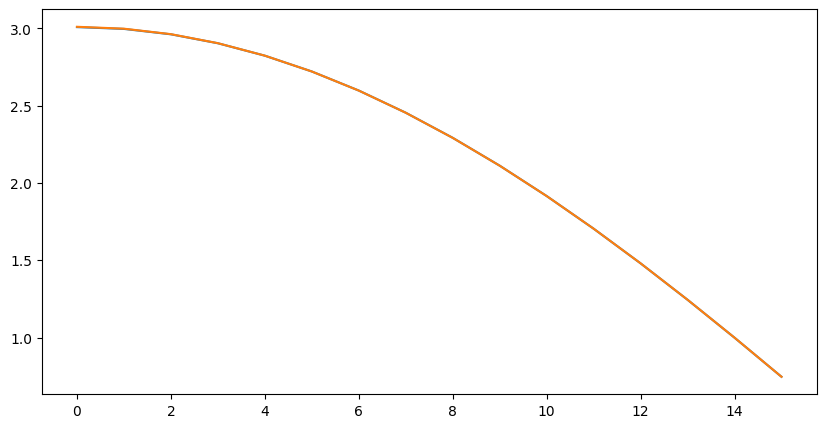

array([ 3.01015697e+00, -1.88299028e-05, -8.78355901e-02,  1.56820568e+00])

In [15]:
plt.figure(figsize = (10, 5))
plt.plot(data[0], data[1])
plt.plot(data[0], signal(data[0], params[0], params[1], params[2], params[3]))
plt.show()
params

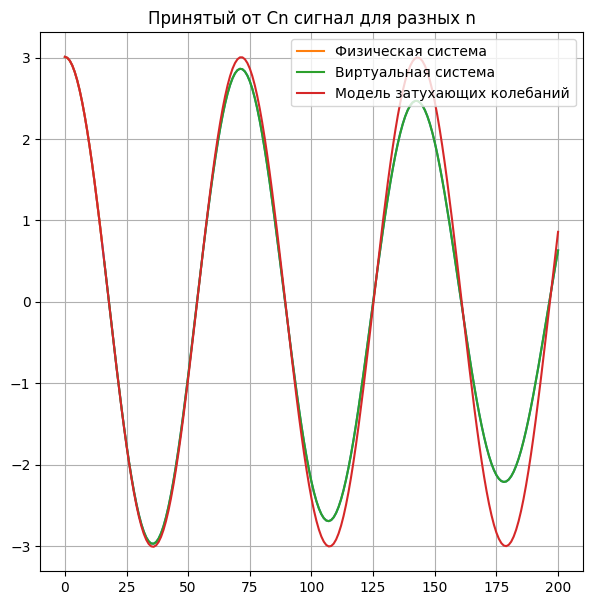

In [16]:
Cn_model = signal(NPa, params[0], params[1], params[2], params[3])

plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, Cn_model,
        label = "Модель затухающих колебаний")
plt.legend()
plt.grid()

In [17]:
print(f"Относительная ошибка по квадратам: {rel_squared_error(Cn, Cn_model)}")
print(f"Относительная ошибка по модулям: {rel_abs_error(Cn, Cn_model)}")
print(f"Средний модуль ошибки: {MAE(Cn, Cn_model)}")
print(f"Средний квадрат ошибки: {MSE(Cn, Cn_model)}")

Относительная ошибка по квадратам: 0.026647760516758
Относительная ошибка по модулям: 0.12606452870119067
Средний модуль ошибки: 0.21151947194473397
Средний квадрат ошибки: 0.09480925710464293


## Моделирование приемной системы

In [18]:
Result = CnU(a, Cn_model)

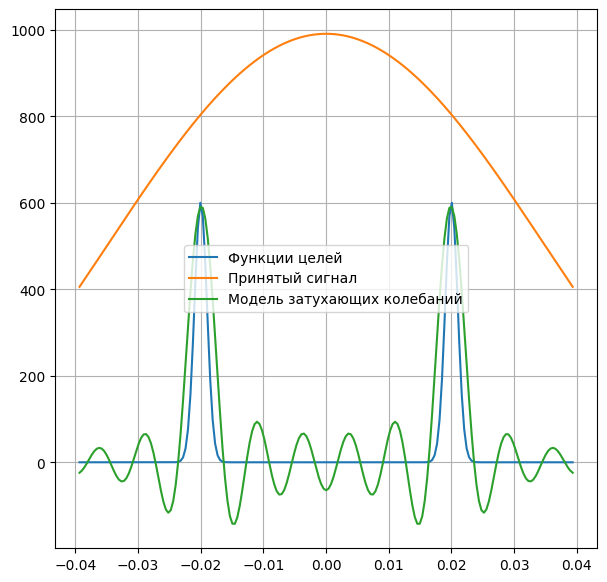

In [19]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result), label = "Модель затухающих колебаний")
plt.legend()
plt.grid()
plt.show()

## Полносвязная нейронная сеть

In [20]:
from sklearn.neural_network import MLPRegressor

In [21]:
regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(18), random_state=1, activation = "tanh")

In [22]:
regr.fit(data[0].reshape(-1, 1), data[1])

MLPRegressor(activation='tanh', alpha=1e-05, hidden_layer_sizes=18,
             random_state=1, solver='lbfgs')

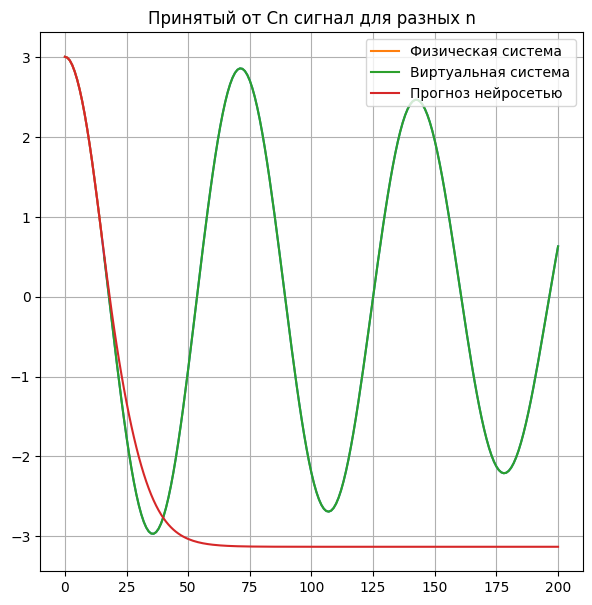

In [23]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, regr.predict(NPa.reshape(-1, 1)), label = "Прогноз нейросетью")
plt.legend()
plt.grid()

In [248]:
Cn_ff = regr.predict(NPa.reshape(-1, 1))

In [250]:
Result_ff = CnU(a, Cn_ff)

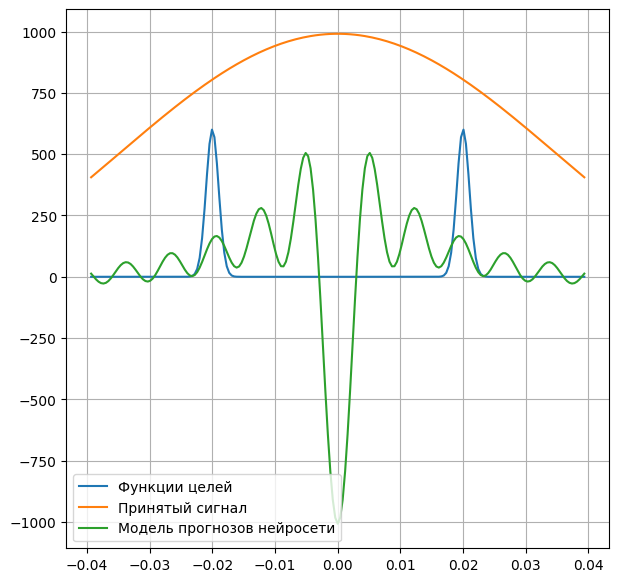

In [252]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result_ff), label = "Модель прогнозов нейросети")
plt.legend()
plt.grid()
plt.show()

## pytorch нейронная сеть siren

In [241]:
import torch
from torch import nn
from siren_pytorch import SirenNet

net = SirenNet(
    dim_in = 1,                        # input dimension, ex. 2d coor
    dim_hidden = 10,                  # hidden dimension
    dim_out = 1,                       # output dimension, ex. rgb value
    num_layers = 2,                    # number of layers
    final_activation = nn.Identity(),   # activation of final layer (nn.Identity() for direct output)
    w0_initial = 0.05 # different signals may require different omega_0 in the first layer - this is a hyperparameter
)

In [242]:
epochs = 2000
alpha = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr = alpha)
loss_func = nn.MSELoss()

data_torch_x = torch.tensor(data[0].reshape(-1, 1), dtype=torch.float)
data_torch_y = torch.tensor(data[1].reshape(-1, 1), dtype=torch.float)

In [243]:
data_torch_x

tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.]])

In [244]:
for iter in range(0, epochs):
    optimizer.zero_grad()
    predictions = net(data_torch_x)
    loss = loss_func(predictions, data_torch_y)
    loss.backward()
    optimizer.step()

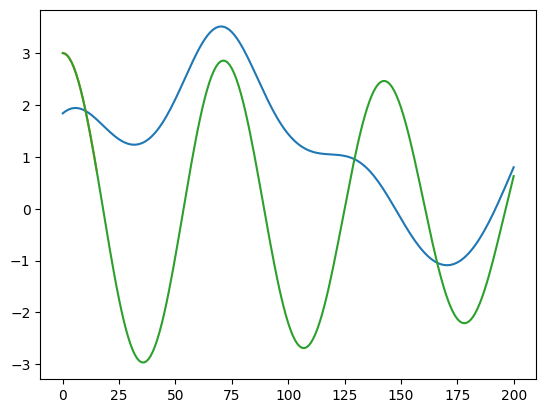

In [245]:
NPa_torch = torch.tensor(NPa.reshape(-1, 1), dtype = torch.float)

plt.plot(net(NPa_torch).detach())
plt.plot(data_torch_y)
plt.plot(Cn)

In [260]:
Cn_siren = net(NPa_torch).detach().numpy().reshape(1, -1)

In [263]:
Result_siren = CnU(a, Cn_siren)

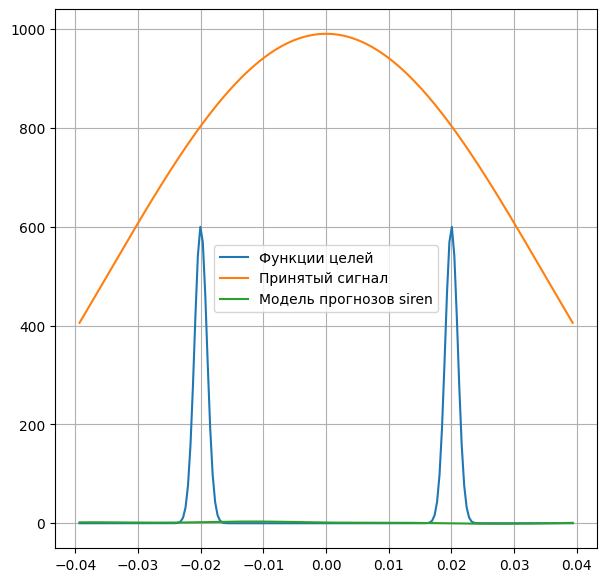

In [265]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result_siren), label = "Модель прогнозов siren")
plt.legend()
plt.grid()
plt.show()

## Авторегрессия с коэффициентами методом Burg

In [272]:
from numpy import cos
import numpy as np 

def  burg_AR(m,  x):
    """
    Based on Collomb's C++ code, pp. 10-11
    Burgs Method, algorithm and recursion
      m - number of lags in autoregressive model.
      x  - data vector to approximate.
    """
    N = len(x)-1
    coeffs = np.zeros(m)
    
    # initialize Ak
    Ak    = np.zeros(m+1)
    Ak[0] = 1.0 
    # initialize f and b.
    f  = x.copy()
    b = x.copy()
    # Initialize Dk
    Dk = 0.0
    for j in range(N+1):
        Dk += 2.0 * f[j] ** 2 
    Dk -= (f[0] ** 2) + (b[ N ] ** 2) 

    #Burg recursion
    for k in range(m):
        # compute mu
        mu = 0.0;
        for n in range(N-k):
            mu += f[ n + k + 1 ] * b[ n ]
        mu *= -2.0 / Dk
        
        # update Ak
        maxn = int((k+1)/2 + 1) # rounds down 
        for n in range(maxn):
            t1 = Ak[ n ] + mu * Ak[ k + 1 - n ]
            t2 = Ak[ k + 1 - n ] + mu * Ak[ n ]
            Ak[ n ] = t1
            Ak[ k + 1 - n ] = t2
        #update f and b
        for n in range(N-k):
            t1 = f[ n + k + 1 ] + mu * b[n]
            t2 = b[ n ] + mu * f[ n + k + 1]
            f[ n + k + 1 ] = t1
            b[ n ] = t2
            
        #update Dk
        Dk = ( 1.0 - mu ** 2) * Dk - (f[ k + 1 ] ** 2) - (b[ N - k - 1 ] ** 2)
    
    # assign coefficients.
    coeffs[:] = Ak[1:]
    
    return coeffs

In [301]:
coeffs = burg_AR(len(data[0])//2, data[1])
coeffs

array([ -5.34764249,  11.64299568, -13.06586199,   7.8848486 ,
        -2.5675489 ,   0.7078465 ,  -0.34759146,   0.09295407])

In [302]:
def predict_AR(data_array, coeffs, h = 100):
    for tick in range(h):
        result = np.sum(coeffs * data_array[-(len(coeffs) + 1):-1])
        data_array = np.append(data_array, result)
    return data_array

In [303]:
predict_AR(data[1], coeffs, 100)

array([ 3.00795393e+00,  2.99629502e+00,  2.96140958e+00,  2.90357073e+00,
        2.82323125e+00,  2.72102005e+00,  2.59773715e+00,  2.45434737e+00,
        2.29197273e+00,  2.11188354e+00,  1.91548840e+00,  1.70432306e+00,
        1.48003831e+00,  1.24438691e+00,  9.99209805e-01,  7.46421556e-01,
       -2.59773707e+00, -2.45434728e+00, -2.57880400e+00, -1.28845349e+00,
       -3.40427352e+00,  5.11267833e+00, -2.06484718e+01,  2.53044022e+01,
       -2.53003718e+01,  3.07398604e+01, -6.57978243e+01,  1.66160708e+02,
       -3.62037534e+02,  6.72078311e+02, -1.01477403e+03,  1.45285897e+03,
       -2.36116847e+03,  4.55611200e+03, -9.12449333e+03,  1.71941540e+04,
       -2.97198472e+04,  4.85328285e+04, -7.99052576e+04,  1.39557327e+05,
       -2.56216260e+05,  4.71873909e+05, -8.43090179e+05,  1.45684242e+06,
       -2.48421038e+06,  4.28875054e+06, -7.57917719e+06,  1.35785539e+07,
       -2.42367075e+07,  4.26776084e+07, -7.43111937e+07,  1.29208023e+08,
       -2.26272580e+08,  

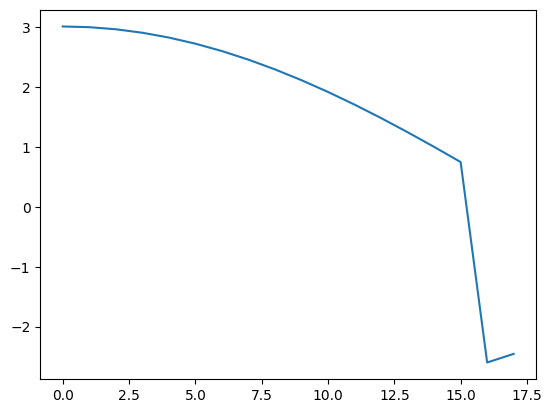

In [304]:
plt.plot(predict_AR(data[1], coeffs, 2))